In [1]:
import pickle
# from functools import partial
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)
import seaborn as sns
# import plotly.express as px

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.dummy import DummyClassifier
# feature selection
from sklearn.feature_selection import chi2, SelectPercentile, SelectKBest,f_regression,mutual_info_regression
# model selection
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import (r2_score, mean_squared_error, accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve, make_scorer,
                             confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay)

# models
from statsmodels.tsa.arima.model import ARIMA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression, SGDRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,ExtraTreesRegressor,ExtraTreesClassifier
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
from sklearn.decomposition import PCA,TruncatedSVD
# model explainability
import shap

# enable reload of changed files
%reload_ext autoreload
%autoreload 2

# plot inline
#%matplotlib inline

# make it pretty
#from rich.console import Console
#from rich import inspect
#con = Console()
#ins = partial(inspect, methods=True)
#%reload_ext rich
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, OrdinalEncoder, FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.datasets import make_classification
#from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (precision_recall_curve,PrecisionRecallDisplay)

#def mod_eval(xtrain,xtest,ytrain,ytest,xfc,regressor,probs=0):
#    kpi=pd.DataFrame(index=['mae','rmse','mape'])
#    fc=pd.DataFrame(index=list(range(1,25)))
#    
#    regressor[1].fit(xtrain,ytrain)
#    fctest=regressor[1].predict(xtest)
#    mae = np.mean(abs(fctest - ytest.values))
#    mape=(fctest - ytest.values)/ytest.values;
#    mape=100*np.mean(abs(mape[np.isfinite(mape)]))
#    rmse = np.sqrt(np.mean((fctest - ytest.values) ** 2))
#    
#    kpi.loc[:,regressor[0]]=[mae,rmse,mape]
#    fc.loc[:,regressor[0]]=regressor[1].predict(xfc)
#    
#    if probs==1:
#        p=prob_eval(regressor,xfc)
#        fc=pd.concat([fc,p],axis=1)
#    return kpi, fc
#
#def prob_eval(regressor,xfc):
#    fc=pd.DataFrame(index=list(range(1,25)))

C:\Users\JJIMENEZG\Anaconda3\envs\data_translator3.9\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# lectura de variables para pronostico de PML y OVEMEM
rawdata = pd.read_excel('data\input_vars.xlsx')
print(rawdata.dtypes,rawdata.isnull().sum())

Fecha      datetime64[ns]
Mes                 int64
Dia                 int64
Diasem              int64
Hora                int64
Fest                int64
MDA               float64
MTR               float64
Spread            float64
Bin                 int64
MW                float64
SIN               float64
FC                  int64
MRO               float64
TEM                 int64
EO                float64
FV                float64
RES               float64
MDA2              float64
MDA3              float64
MDA4              float64
MW2               float64
MW3               float64
MW4               float64
EO1               float64
FV1               float64
HSC1              float64
SIN2              float64
Spread4           float64
FC1                 int64
Bin3                int64
Binh3               int64
Bin7                int64
Bin14               int64
dtype: object Fecha      0
Mes        0
Dia        0
Diasem     0
Hora       0
Fest       0
MDA        0
MTR        

In [8]:
df_datestr=rawdata[['Fecha','Hora']]
df_datetime=pd.DataFrame({'Fecha': rawdata.Fecha
                         +pd.to_timedelta(rawdata.Hora,unit='h')})

df_pml=rawdata.copy()
df_pml['Fecha']=df_datetime['Fecha'].dt.strftime('%d/%m/%Y %H')
df_pml.set_index('Fecha',inplace=True)

In [9]:
date_rng=['01/07/2022 01','01/01/2023 00']

In [10]:
#Selección de datos que se utilizan en entrenamiento y prueba de algoritmos
hist_data=df_pml['01/07/2022 01':'01/01/2023 00']

# Seleccion de datos que se utilizan en validación
val_data=df_pml['01/01/2023 01':]
val_data

,Mes,Dia,Diasem,Hora,Fest,MDA,MTR,Spread,Bin,MW,...,EO1,FV1,HSC1,SIN2,Spread4,FC1,Bin3,Binh3,Bin7,Bin14
Fecha,,,,,,,,,,,,,,,,,,,,,
01/01/2023 01,1,1,1,1,1,316.96,347.97,31.01,1,467.638,...,856.207,0.000,2.200,27733.012731,-22.06,0,1,1,0,0
01/01/2023 02,1,1,1,2,1,122.18,329.72,207.54,1,458.698,...,831.698,0.000,2.200,27733.012731,-95.82,0,1,1,0,1
01/01/2023 03,1,1,1,3,1,303.64,328.55,24.91,1,448.494,...,812.844,0.000,2.200,27733.012731,-97.08,0,1,1,1,0
01/01/2023 04,1,1,1,4,1,111.55,292.46,180.91,1,442.856,...,782.224,0.000,2.200,27733.012731,-57.44,0,0,1,1,0
01/01/2023 05,1,1,1,5,1,63.46,292.40,228.94,1,429.287,...,724.389,0.000,2.200,27733.012731,-82.93,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14/01/2023 20,1,14,7,20,0,568.65,0.00,-568.65,0,680.269,...,3019.987,0.293,3.225,29630.229167,-782.70,1,0,0,0,1
14/01/2023 21,1,14,7,21,0,515.84,0.00,-515.84,0,675.218,...,3190.064,0.000,3.225,29630.229167,-652.36,0,0,0,0,1
14/01/2023 22,1,14,7,22,0,511.05,0.00,-511.05,0,661.245,...,3212.694,0.000,3.225,29630.229167,-175.33,0,0,0,0,1


In [11]:
hist_data['MDA4']

Fecha
01/07/2022 01    1179.13
01/07/2022 02    1155.25
01/07/2022 03    1128.81
01/07/2022 04    1134.40
01/07/2022 05    1115.40
                  ...   
31/12/2022 20     910.03
31/12/2022 21     887.30
31/12/2022 22     871.94
31/12/2022 23     846.68
01/01/2023 00     808.34
Name: MDA4, Length: 4416, dtype: float64

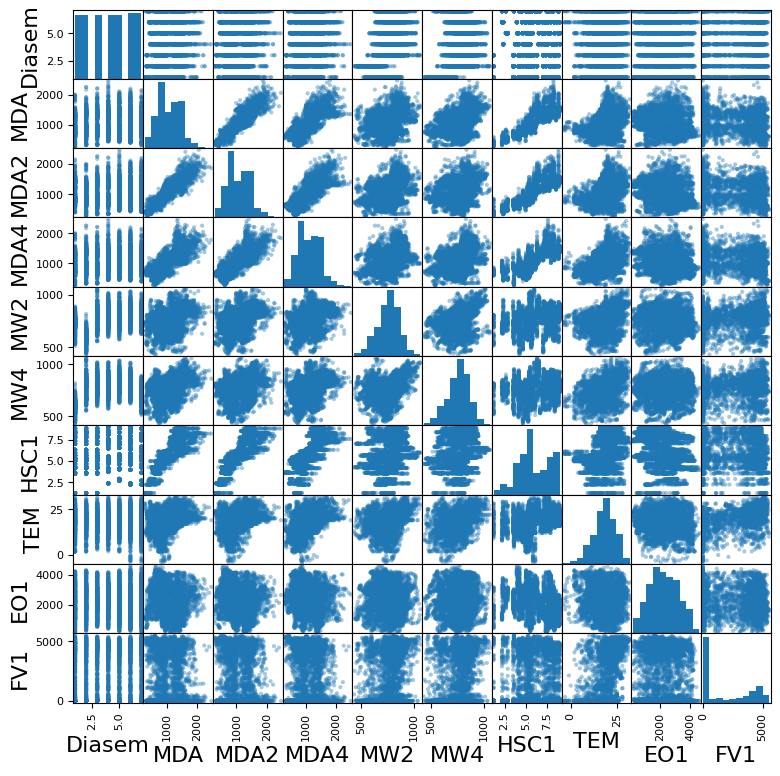

In [12]:
pml_data=hist_data[['Diasem','MDA','MDA2','MDA4','MW2','MW4','HSC1','TEM','EO1','FV1']]
#pml_data=hist_data[['MDA','MDA2','MDA3','MDA4','MW2','MW3','MW4','HSC1','TEM']]
pd.plotting.scatter_matrix(pml_data,alpha=0.4);

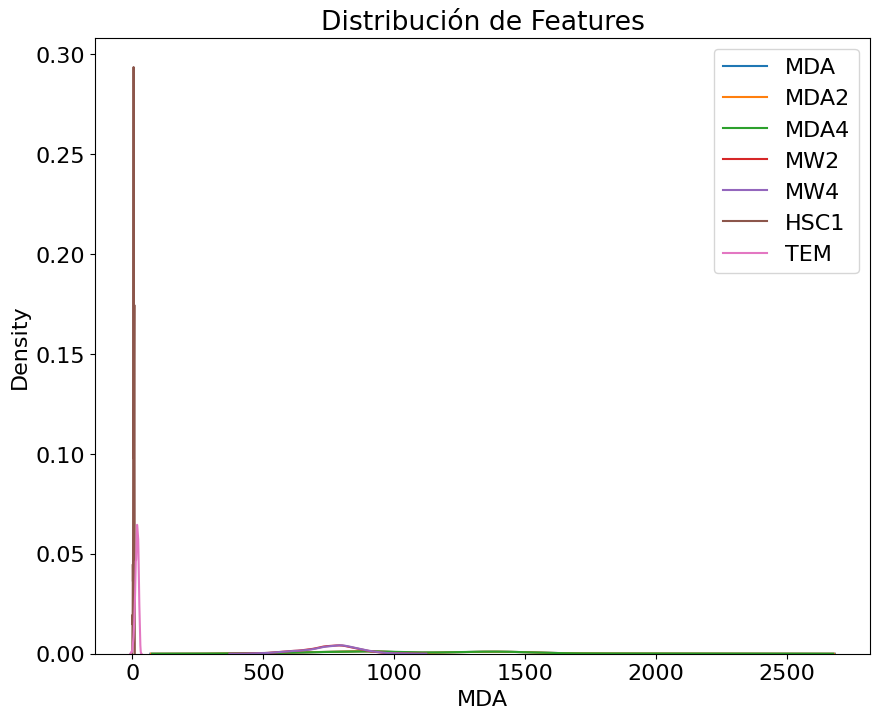

In [13]:
fig,ax=plt.subplots(figsize=(10, 8))
ax.set_title('Distribución de Features')

sns.kdeplot(pml_data['MDA'],ax=ax,label='MDA')
sns.kdeplot(pml_data['MDA2'],ax=ax,label='MDA2')
#sns.kdeplot(pml_data['MDA3'],ax=ax,label='MDA3')
sns.kdeplot(pml_data['MDA4'],ax=ax,label='MDA4')
sns.kdeplot(pml_data['MW2'],ax=ax,label='MW2')
#sns.kdeplot(pml_data['MW3'],ax=ax,label='MW3')
sns.kdeplot(pml_data['MW4'],ax=ax,label='MW4')
sns.kdeplot(pml_data['HSC1'],ax=ax,label='HSC1')
sns.kdeplot(pml_data['TEM'],ax=ax,label='TEM');
#sns.kdeplot(pml_data['EO1'],ax=ax,label='EO1')
#sns.kdeplot(pml_data['FV1'],ax=ax,label='FV1');
ax.legend();

In [14]:
X,y=pml_data.drop('MDA',axis=1),pml_data['MDA']
cols=X.columns.tolist()

In [15]:
# Input vars for LMP
# Selección de variable a pronosticar y datos de entrada a modelos
X_train,X_test,y_train,y_test=train_test_split(X,y,shuffle=False)
X_train

,Diasem,MDA2,MDA4,MW2,MW4,HSC1,TEM,EO1,FV1
Fecha,,,,,,,,,
01/07/2022 01,6,1128.67,1179.13,914.519,881.700,6.545,17,2119.700,0.000
01/07/2022 02,6,1128.05,1155.25,892.112,859.318,6.545,20,2137.464,0.000
01/07/2022 03,6,1081.02,1128.81,866.957,835.702,6.545,21,2137.813,0.000
01/07/2022 04,6,1075.36,1134.40,854.254,826.976,6.545,21,2060.523,0.000
01/07/2022 05,6,1067.40,1115.40,851.086,819.218,6.545,22,1988.454,0.000
...,...,...,...,...,...,...,...,...,...
15/11/2022 20,3,791.33,585.38,824.931,908.330,3.595,8,1566.091,0.024
15/11/2022 21,3,776.50,495.27,823.055,894.700,3.595,7,1625.693,0.000
15/11/2022 22,3,699.24,487.37,807.959,880.610,3.595,7,1736.962,0.000


In [16]:
X_test

,Diasem,MDA2,MDA4,MW2,MW4,HSC1,TEM,EO1,FV1
Fecha,,,,,,,,,
16/11/2022 01,4,628.30,487.26,732.567,759.630,5.045,6,2111.492,0.000
16/11/2022 02,4,621.73,471.35,718.036,745.690,5.045,7,2132.136,0.000
16/11/2022 03,4,619.90,470.39,699.941,729.970,5.045,8,2165.229,0.000
16/11/2022 04,4,616.26,457.57,695.123,724.910,5.045,8,2177.911,0.000
16/11/2022 05,4,604.48,461.82,696.738,722.770,5.045,8,2166.569,0.000
...,...,...,...,...,...,...,...,...,...
31/12/2022 20,7,592.72,910.03,672.048,719.535,2.200,17,1236.534,0.023
31/12/2022 21,7,600.16,887.30,668.302,700.944,2.200,15,1204.235,0.000
31/12/2022 22,7,567.55,871.94,659.312,677.578,2.200,14,1138.072,0.000


In [17]:
# Create scaler object
ss = StandardScaler()
# Fit scaler to training data
ss.fit(X_train)

# Transform train and test X data and save as new variables
X_train_scaled = pd.DataFrame(ss.transform(X_train),columns=cols,index=X_train.index)
X_test_scaled = pd.DataFrame(ss.transform(X_test),columns=cols,index=X_test.index)

In [18]:
X_test_scaled

,Diasem,MDA2,MDA4,MW2,MW4,HSC1,TEM,EO1,FV1
Fecha,,,,,,,,,
16/11/2022 01,0.003600,-1.488294,-2.042968,-0.360276,-0.138160,-0.658645,-2.690835,0.039104,-0.891886
16/11/2022 02,0.003600,-1.506109,-2.088656,-0.498498,-0.270312,-0.658645,-2.493853,0.062949,-0.891886
16/11/2022 03,0.003600,-1.511071,-2.091413,-0.670621,-0.419338,-0.658645,-2.296871,0.101174,-0.891886
16/11/2022 04,0.003600,-1.520941,-2.128229,-0.716451,-0.467308,-0.658645,-2.296871,0.115823,-0.891886
16/11/2022 05,0.003600,-1.552884,-2.116024,-0.701089,-0.487595,-0.658645,-2.296871,0.102722,-0.891886
...,...,...,...,...,...,...,...,...,...
31/12/2022 20,1.494189,-1.584772,-0.828896,-0.935945,-0.518263,-2.154946,-0.524036,-0.971541,-0.891875
31/12/2022 21,1.494189,-1.564598,-0.894170,-0.971578,-0.694506,-2.154946,-0.917999,-1.008849,-0.891886
31/12/2022 22,1.494189,-1.653022,-0.938279,-1.057093,-0.916017,-2.154946,-1.114981,-1.085272,-0.891886


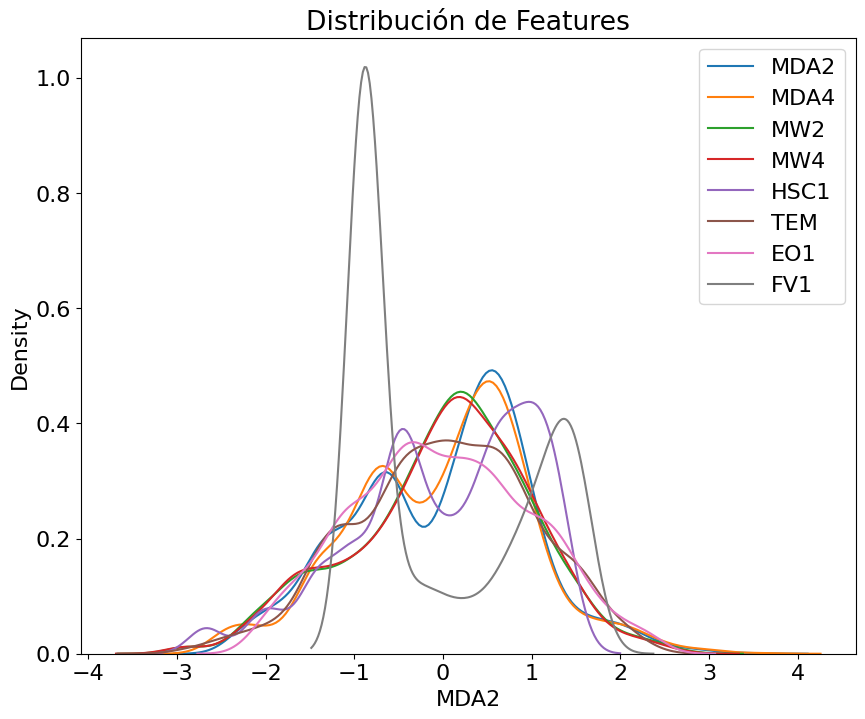

In [19]:
fig,ax=plt.subplots(figsize=(10, 8))
ax.set_title('Distribución de Features')

sns.kdeplot(X_train_scaled['MDA2'],ax=ax,label='MDA2')
#sns.kdeplot(X_train_scaled['MDA3'],ax=ax,label='MDA3')
sns.kdeplot(X_train_scaled['MDA4'],ax=ax,label='MDA4')
sns.kdeplot(X_train_scaled['MW2'],ax=ax,label='MW2')
#sns.kdeplot(X_train_scaled['MW3'],ax=ax,label='MW3')
sns.kdeplot(X_train_scaled['MW4'],ax=ax,label='MW4')
sns.kdeplot(X_train_scaled['HSC1'],ax=ax,label='HSC1')
sns.kdeplot(X_train_scaled['TEM'],ax=ax,label='TEM')
sns.kdeplot(X_train_scaled['EO1'],ax=ax,label='EO1')
sns.kdeplot(X_train_scaled['FV1'],ax=ax,label='FV1');
ax.legend();

In [20]:
#fs=SelectKBest(score_func=f_regression,k='all')
#fs.fit(X_train,y_train)
#plt.barh(cols,fs.pvalues_);

In [21]:
#X_sc_bf=pd.DataFrame(fs.transform(X_train_scaled),columns=cols,index=X_train_scaled.index)
#X_sc_bf

In [22]:
class ClfSwitcher(BaseEstimator):
    def __init__(self,model):
        """
            A Custom BaseEstimator that can switch between classifiers.
            :param estimator: sklearn object - The classifier
        """ 
        self.model=model
        self.estimator = self.model
    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

In [23]:
model_list=[Ridge(),Lasso(),ElasticNet(),
            RandomForestRegressor(),ExtraTreesRegressor(),
            XGBRegressor()]
params=[{'selector__model__alpha':np.logspace(-2,4,100)},
        {'selector__model__alpha':np.logspace(-2,4,100)},
        {'selector__model__alpha':np.logspace(-2,4,100),
         'selector__model__l1_ratio': list(np.linspace(0.01,0.99,25))},
        {'selector__model__n_estimators': np.arange(50,1050,100),
         'selector__model__max_depth': list(range(1,7)),
         'selector__model__random_state':[16]},
        {'selector__model__n_estimators': np.arange(50,1050,100),
         'selector__model__max_depth': list(range(1,7)),
         'selector__model__random_state':[16]},
        {'selector__model__n_estimators': np.arange(50,1050,100),
         'selector__model__max_depth': list(range(1,7))}
       ]

In [21]:
res=[]
for k,reg in enumerate(mdl):
    pipe_tst=Pipeline(steps=[
        ('preprocessor',StandardScaler()),
        ('selector',ClfSwitcher(reg))
    ])
    gs=GridSearchCV(pipe_tst,params[k])
    gs.fit(X_train,y_train)
    res.append([gs.best_estimator_,gs.best_params_,gs.best_score_,gs.score(X_test,y_test)])
    
res_6m=pd.DataFrame(res,columns=['Model','Params','TrainR2','TestR2'])

In [37]:
res_6m=pd.DataFrame(res,columns=['Model','Params','TrainR2','TestR2'])
res_6m

,Model,Params,TrainR2,TestR2
0,"(StandardScaler(), ClfSwitcher(model=Ridge(alp...",{'selector__model__alpha': 0.01},0.429034,0.502714
1,"(StandardScaler(), ClfSwitcher(model=Lasso(alp...",{'selector__model__alpha': 2.31012970008316},0.434199,0.507067
2,"(StandardScaler(), ClfSwitcher(model=ElasticNe...","{'selector__model__alpha': 0.7564633275546291,...",0.429853,0.502119
3,"(StandardScaler(), ClfSwitcher(model=RandomFor...","{'selector__model__max_depth': 6, 'selector__m...",-0.535183,0.447369
4,"(StandardScaler(), ClfSwitcher(model=ExtraTree...","{'selector__model__max_depth': 6, 'selector__m...",-0.131433,0.543862
5,"(StandardScaler(), ClfSwitcher(model=XGBRegres...","{'selector__model__max_depth': 2, 'selector__m...",-0.366488,0.546859


In [45]:
best_model=res_6m['Model'][res_6m['TestR2']==max(res_6m['TestR2'])].values[0]
best_model.

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('selector',
                 ClfSwitcher(model=XGBRegressor(base_score=0.5,
                                                booster='gbtree',
                                                callbacks=None,
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=1,
                                                early_stopping_rounds=None,
                                                enable_categorical=False,
                                                eval_metric=None, gamma=0,
                                                gpu_id=-1,
                                                grow_policy='depthwise',
                                                importance_type=None,
                                                interaction_constraints='',
                 

In [46]:
G=val_data.loc['12/01/2023 01':'13/01/2023 00',cols];H=val_data.loc['12/01/2023 01':'13/01/2023 00','MDA']
best_model=res_6m['Model'][res_6m['TestR2']==max(res_6m['TestR2'])].values[0]
y_hat=best_model.predict(G)
ape=abs(H.values-y_hat)/H.values
mape=ape.mean()
print(best_model.score(G,H),mape)

0.26739574018980905 0.13725056272603103


In [62]:
date_rng=['01/01/2022 01','01/01/2023 00']
hist_data=df_pml[date_rng[0]:date_rng[1]]

val_data=df_pml['01/01/2023 01':]
val_data

,Mes,Dia,Diasem,Hora,Fest,MDA,MTR,Spread,Bin,MW,...,EO1,FV1,HSC1,SIN2,Spread4,FC1,Bin3,Binh3,Bin7,Bin14
Fecha,,,,,,,,,,,,,,,,,,,,,
01/01/2023 01,1,1,1,1,1,316.96,347.97,31.01,1,467.638,...,856.207,0.000,2.200,27733.012731,-22.06,0,1,1,0,0
01/01/2023 02,1,1,1,2,1,122.18,329.72,207.54,1,458.698,...,831.698,0.000,2.200,27733.012731,-95.82,0,1,1,0,1
01/01/2023 03,1,1,1,3,1,303.64,328.55,24.91,1,448.494,...,812.844,0.000,2.200,27733.012731,-97.08,0,1,1,1,0
01/01/2023 04,1,1,1,4,1,111.55,292.46,180.91,1,442.856,...,782.224,0.000,2.200,27733.012731,-57.44,0,0,1,1,0
01/01/2023 05,1,1,1,5,1,63.46,292.40,228.94,1,429.287,...,724.389,0.000,2.200,27733.012731,-82.93,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14/01/2023 20,1,14,7,20,0,568.65,0.00,-568.65,0,680.269,...,3019.987,0.293,3.225,29630.229167,-782.70,1,0,0,0,1
14/01/2023 21,1,14,7,21,0,515.84,0.00,-515.84,0,675.218,...,3190.064,0.000,3.225,29630.229167,-652.36,0,0,0,0,1
14/01/2023 22,1,14,7,22,0,511.05,0.00,-511.05,0,661.245,...,3212.694,0.000,3.225,29630.229167,-175.33,0,0,0,0,1


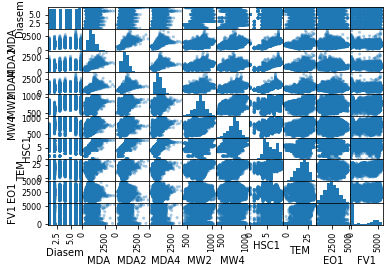

In [63]:
pml_data=hist_data[['Diasem','MDA','MDA2','MDA4','MW2','MW4','HSC1','TEM','EO1','FV1']]
#pml_data=hist_data[['MDA','MDA2','MDA3','MDA4','MW2','MW3','MW4','HSC1','TEM']]
pd.plotting.scatter_matrix(pml_data,alpha=0.4);

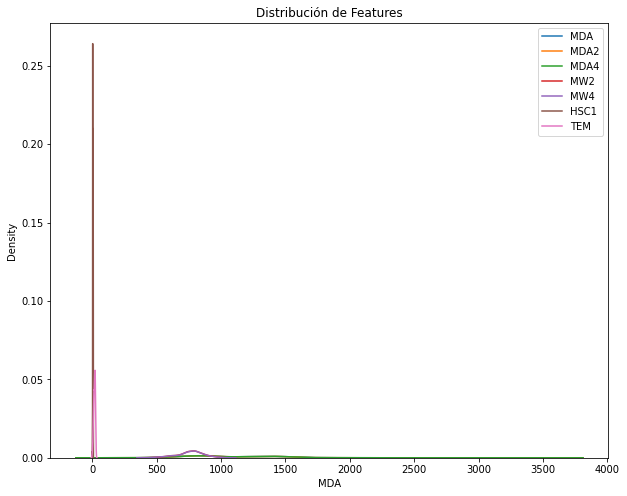

In [64]:
fig,ax=plt.subplots(figsize=(10, 8))
ax.set_title('Distribución de Features')

sns.kdeplot(pml_data['MDA'],ax=ax,label='MDA')
sns.kdeplot(pml_data['MDA2'],ax=ax,label='MDA2')
#sns.kdeplot(pml_data['MDA3'],ax=ax,label='MDA3')
sns.kdeplot(pml_data['MDA4'],ax=ax,label='MDA4')
sns.kdeplot(pml_data['MW2'],ax=ax,label='MW2')
#sns.kdeplot(pml_data['MW3'],ax=ax,label='MW3')
sns.kdeplot(pml_data['MW4'],ax=ax,label='MW4')
sns.kdeplot(pml_data['HSC1'],ax=ax,label='HSC1')
sns.kdeplot(pml_data['TEM'],ax=ax,label='TEM');
#sns.kdeplot(pml_data['EO1'],ax=ax,label='EO1')
#sns.kdeplot(pml_data['FV1'],ax=ax,label='FV1');
ax.legend();

In [65]:
X,y=pml_data.drop('MDA',axis=1),pml_data['MDA']
cols=X.columns.tolist()

In [66]:
# Input vars for LMP
# Selección de variable a pronosticar y datos de entrada a modelos
X_train,X_test,y_train,y_test=train_test_split(X,y,shuffle=False)

In [67]:
# Create scaler object
ss = StandardScaler()
# Fit scaler to training data
ss.fit(X_train)

# Transform train and test X data and save as new variables
X_train_scaled = pd.DataFrame(ss.transform(X_train),columns=cols,index=X_train.index)
X_test_scaled = pd.DataFrame(ss.transform(X_test),columns=cols,index=X_test.index)

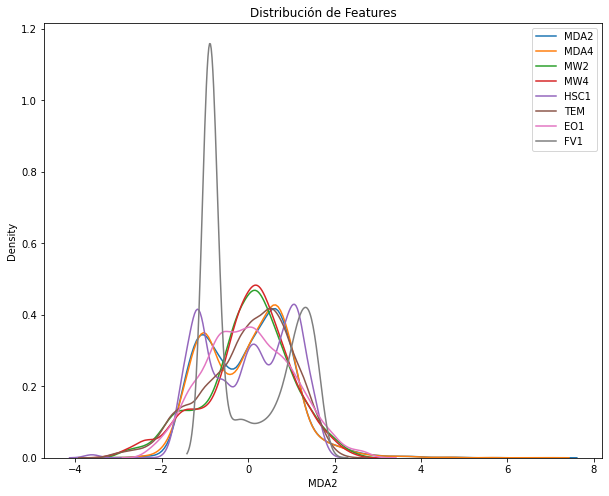

In [68]:
fig,ax=plt.subplots(figsize=(10, 8))
ax.set_title('Distribución de Features')

sns.kdeplot(X_train_scaled['MDA2'],ax=ax,label='MDA2')
#sns.kdeplot(X_train_scaled['MDA3'],ax=ax,label='MDA3')
sns.kdeplot(X_train_scaled['MDA4'],ax=ax,label='MDA4')
sns.kdeplot(X_train_scaled['MW2'],ax=ax,label='MW2')
#sns.kdeplot(X_train_scaled['MW3'],ax=ax,label='MW3')
sns.kdeplot(X_train_scaled['MW4'],ax=ax,label='MW4')
sns.kdeplot(X_train_scaled['HSC1'],ax=ax,label='HSC1')
sns.kdeplot(X_train_scaled['TEM'],ax=ax,label='TEM')
sns.kdeplot(X_train_scaled['EO1'],ax=ax,label='EO1')
sns.kdeplot(X_train_scaled['FV1'],ax=ax,label='FV1');
ax.legend();

In [69]:
import time
start_time = time.time()

In [70]:
res=[]
for k,reg in enumerate(mdl):
    pipe_tst=Pipeline(steps=[
        ('preprocessor',StandardScaler()),
        ('selector',ClfSwitcher(reg))
    ])
    gs=GridSearchCV(pipe_tst,params[k])
    gs.fit(X_train,y_train)
    res.append([gs.best_estimator_,gs.best_params_,gs.best_score_,gs.score(X_test,y_test)])
    
res_12m=pd.DataFrame(res,columns=['Model','Params','TrainR2','TestR2'])

In [71]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 1631.5437726974487 seconds ---


In [72]:
G=val_data.loc['12/01/2023 01':'13/01/2023 00',cols];H=val_data.loc['12/01/2023 01':'13/01/2023 00','MDA']
best_model=res_12m['Model'][res_12m['TestR2']==max(res_12m['TestR2'])].values[0]
y_hat=best_model.predict(G)
ape=abs(H.values-y_hat)/y_hat
mape=ape.mean()
print(best_model.score(G,H),mape)

0.25432001199161003 0.14061087339250064


In [73]:
res_12m

,Model,Params,TrainR2,TestR2
0,"(StandardScaler(), ClfSwitcher(model=Ridge(alp...",{'selector__model__alpha': 231.01297000831582},0.505590,0.590292
1,"(StandardScaler(), ClfSwitcher(model=Lasso(alp...",{'selector__model__alpha': 0.16297508346206444},0.502551,0.612079
2,"(StandardScaler(), ClfSwitcher(model=ElasticNe...",{'selector__model__alpha': 0.04641588833612779...,0.505596,0.583046
3,"(StandardScaler(), ClfSwitcher(model=RandomFor...","{'selector__model__max_depth': 4, 'selector__m...",0.321696,0.419766
4,"(StandardScaler(), ClfSwitcher(model=ExtraTree...","{'selector__model__max_depth': 6, 'selector__m...",0.365138,0.273747
5,"(StandardScaler(), ClfSwitcher(model=XGBRegres...","{'selector__model__max_depth': 2, 'selector__m...",0.449884,0.306916


0.6008602646906311 0.10722036871179562


,Model,Params,TrainR2,TestR2
0,"(StandardScaler(), ClfSwitcher(model=Ridge(alp...",{'selector__model__alpha': 151.99110829529332},0.467684,0.884323
1,"(StandardScaler(), ClfSwitcher(model=Lasso(alp...",{'selector__model__alpha': 0.7564633275546291},0.467495,0.885452
2,"(StandardScaler(), ClfSwitcher(model=ElasticNe...","{'selector__model__alpha': 2.656087782946687, ...",0.468531,0.883554
3,"(StandardScaler(), ClfSwitcher(model=RandomFor...","{'selector__model__max_depth': 6, 'selector__m...",0.029043,0.789817
4,"(StandardScaler(), ClfSwitcher(model=ExtraTree...","{'selector__model__max_depth': 6, 'selector__m...",0.344083,0.820310
5,"(StandardScaler(), ClfSwitcher(model=XGBRegres...","{'selector__model__max_depth': 1, 'selector__m...",0.099191,0.826105


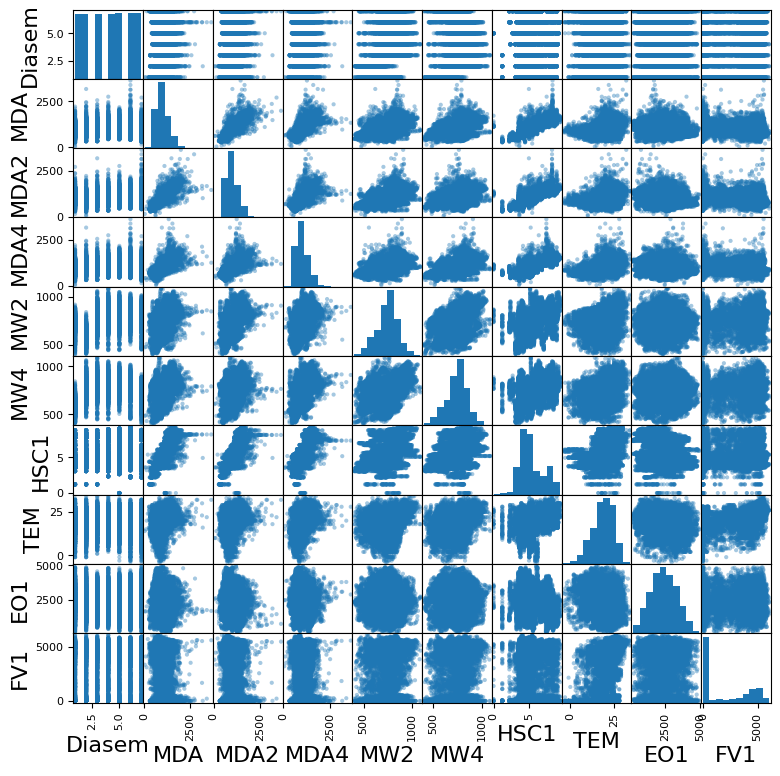

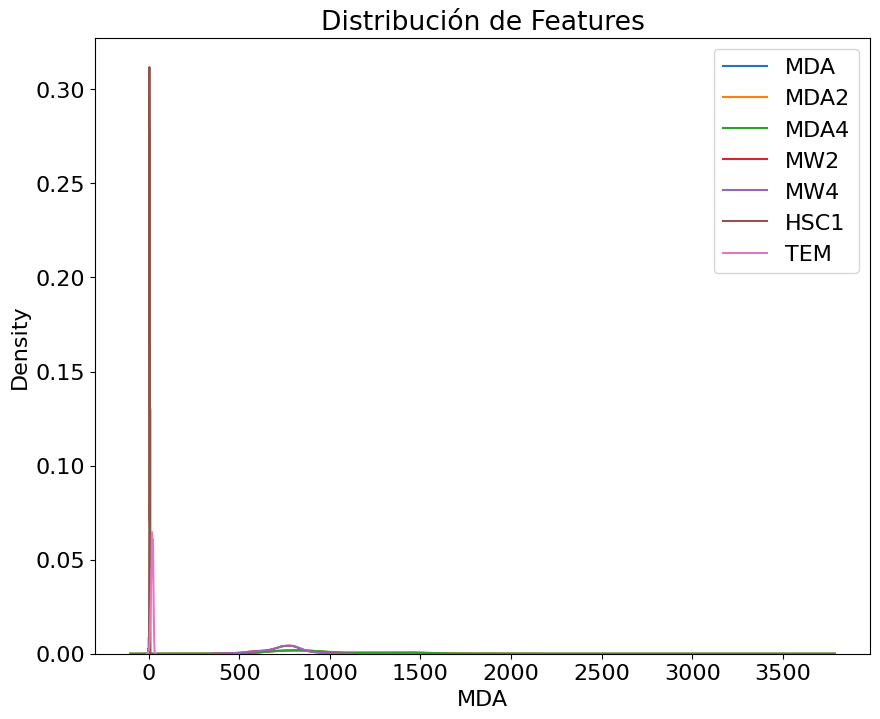

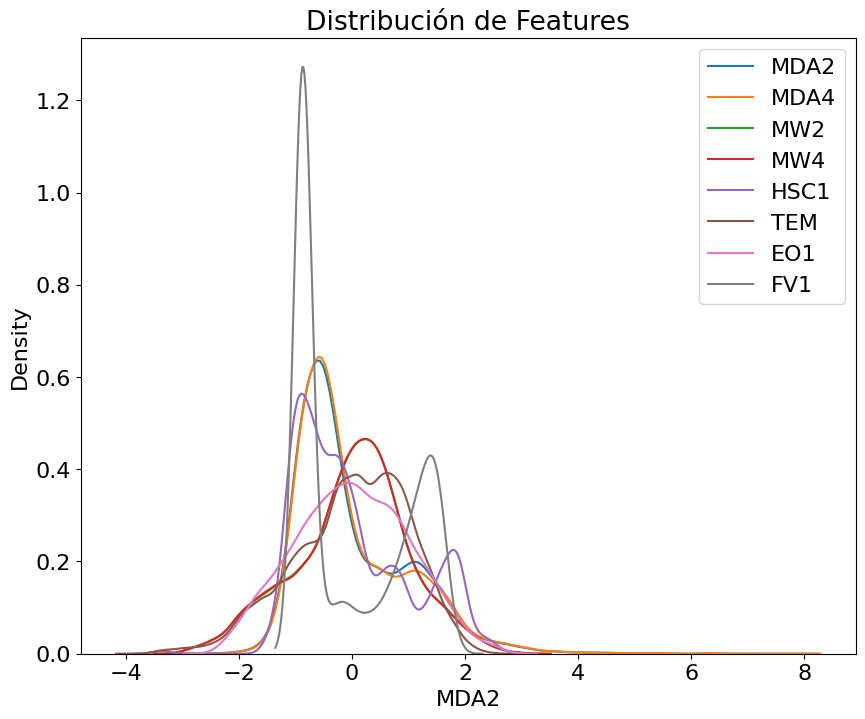

In [25]:
date_rng=['01/07/2021 01','01/01/2023 00']
hist_data=df_pml[date_rng[0]:date_rng[1]]

val_data=df_pml['01/01/2023 01':]
val_data

pml_data=hist_data[['Diasem','MDA','MDA2','MDA4','MW2','MW4','HSC1','TEM','EO1','FV1']]
#pml_data=hist_data[['MDA','MDA2','MDA3','MDA4','MW2','MW3','MW4','HSC1','TEM']]
pd.plotting.scatter_matrix(pml_data,alpha=0.4);

fig,ax=plt.subplots(figsize=(10, 8))
ax.set_title('Distribución de Features')

sns.kdeplot(pml_data['MDA'],ax=ax,label='MDA')
sns.kdeplot(pml_data['MDA2'],ax=ax,label='MDA2')
#sns.kdeplot(pml_data['MDA3'],ax=ax,label='MDA3')
sns.kdeplot(pml_data['MDA4'],ax=ax,label='MDA4')
sns.kdeplot(pml_data['MW2'],ax=ax,label='MW2')
#sns.kdeplot(pml_data['MW3'],ax=ax,label='MW3')
sns.kdeplot(pml_data['MW4'],ax=ax,label='MW4')
sns.kdeplot(pml_data['HSC1'],ax=ax,label='HSC1')
sns.kdeplot(pml_data['TEM'],ax=ax,label='TEM');
#sns.kdeplot(pml_data['EO1'],ax=ax,label='EO1')
#sns.kdeplot(pml_data['FV1'],ax=ax,label='FV1');
ax.legend();

X,y=pml_data.drop('MDA',axis=1),pml_data['MDA']
cols=X.columns.tolist()

# Input vars for LMP
# Selección de variable a pronosticar y datos de entrada a modelos
X_train,X_test,y_train,y_test=train_test_split(X,y,shuffle=False)

# Create scaler object
ss = StandardScaler()
# Fit scaler to training data
ss.fit(X_train)

# Transform train and test X data and save as new variables
X_train_scaled = pd.DataFrame(ss.transform(X_train),columns=cols,index=X_train.index)
X_test_scaled = pd.DataFrame(ss.transform(X_test),columns=cols,index=X_test.index)

fig,ax=plt.subplots(figsize=(10, 8))
ax.set_title('Distribución de Features')

sns.kdeplot(X_train_scaled['MDA2'],ax=ax,label='MDA2')
#sns.kdeplot(X_train_scaled['MDA3'],ax=ax,label='MDA3')
sns.kdeplot(X_train_scaled['MDA4'],ax=ax,label='MDA4')
sns.kdeplot(X_train_scaled['MW2'],ax=ax,label='MW2')
#sns.kdeplot(X_train_scaled['MW3'],ax=ax,label='MW3')
sns.kdeplot(X_train_scaled['MW4'],ax=ax,label='MW4')
sns.kdeplot(X_train_scaled['HSC1'],ax=ax,label='HSC1')
sns.kdeplot(X_train_scaled['TEM'],ax=ax,label='TEM')
sns.kdeplot(X_train_scaled['EO1'],ax=ax,label='EO1')
sns.kdeplot(X_train_scaled['FV1'],ax=ax,label='FV1');
ax.legend();

#start_time = time.time()

res=[]
for k,reg in enumerate(mdl):
    pipe_tst=Pipeline(steps=[
        ('preprocessor',StandardScaler()),
        ('selector',ClfSwitcher(reg))
    ])
    gs=GridSearchCV(pipe_tst,params[k])
    gs.fit(X_train,y_train)
    res.append([gs.best_estimator_,gs.best_params_,gs.best_score_,gs.score(X_test,y_test)])
    
res_18m=pd.DataFrame(res,columns=['Model','Params','TrainR2','TestR2'])

#print("--- %s seconds ---" % (time.time() - start_time))

G=val_data.loc['12/01/2023 01':'13/01/2023 00',cols];H=val_data.loc['12/01/2023 01':'13/01/2023 00','MDA']
best_model=res_18m['Model'][res_18m['TestR2']==max(res_18m['TestR2'])].values[0]
y_hat=best_model.predict(G)
ape=abs(H.values-y_hat)/y_hat
mape=ape.mean()
print(best_model.score(G,H),mape)

res_18m



In [26]:
best_model

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('selector',
                 ClfSwitcher(model=Lasso(alpha=0.7564633275546291)))])

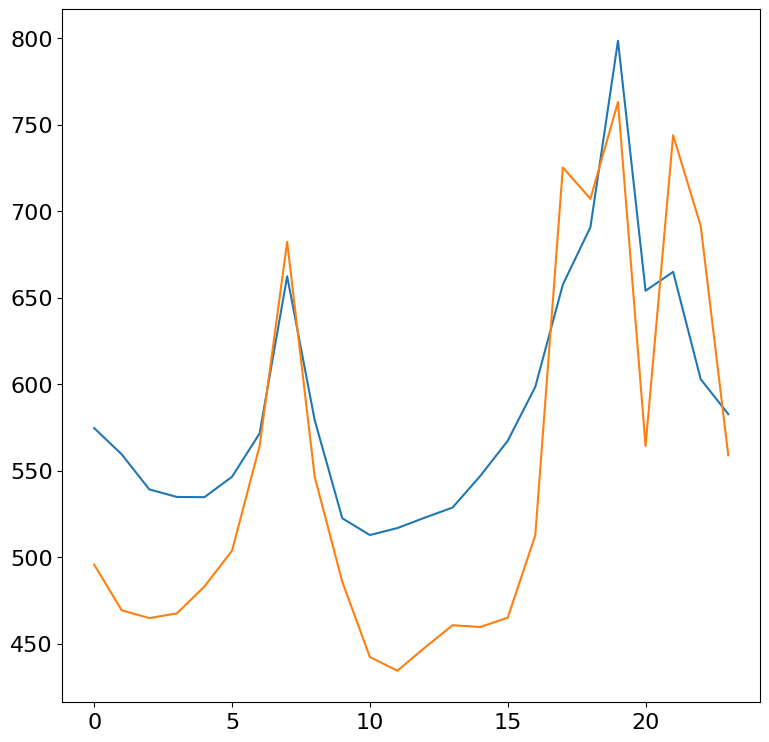

In [28]:
plt.plot(y_hat)
plt.plot(H.values)

In [29]:
res_18m

,Model,Params,TrainR2,TestR2
0,"(StandardScaler(), ClfSwitcher(model=Ridge(alp...",{'selector__model__alpha': 151.99110829529332},0.467684,0.884323
1,"(StandardScaler(), ClfSwitcher(model=Lasso(alp...",{'selector__model__alpha': 0.7564633275546291},0.467495,0.885452
2,"(StandardScaler(), ClfSwitcher(model=ElasticNe...","{'selector__model__alpha': 2.656087782946687, ...",0.468531,0.883554
3,"(StandardScaler(), ClfSwitcher(model=RandomFor...","{'selector__model__max_depth': 6, 'selector__m...",0.029043,0.789817
4,"(StandardScaler(), ClfSwitcher(model=ExtraTree...","{'selector__model__max_depth': 6, 'selector__m...",0.344083,0.820310
5,"(StandardScaler(), ClfSwitcher(model=XGBRegres...","{'selector__model__max_depth': 1, 'selector__m...",0.099191,0.826105


In [30]:
date_val=['12/01/2023 01','13/01/2023 00']

In [38]:
scoresxx=[]
for k in list(range(0,len(res_18m))):
    y_hat=res_18m.loc[k,'Model'].predict(G)
    ape=abs(H.values-y_hat)/y_hat
    mape=ape.mean()
    scoresxx.append([res_18m.loc[k,'Model'].score(G,H),mape])

In [39]:
pd.DataFrame(scoresxx)

,0,1
0,0.584971,0.109295
1,0.600860,0.107220
2,0.513120,0.117168
3,-1.959406,0.230611
4,-2.340483,0.241855
5,-1.815404,0.232362


--- 3051.9662914276123 seconds ---
0.49764520262666967 0.1207142483537974


,Model,Params,TrainR2,TestR2
0,"(StandardScaler(), ClfSwitcher(model=Ridge(alp...",{'selector__model__alpha': 10000.0},-3.513555,0.656807
1,"(StandardScaler(), ClfSwitcher(model=Lasso(alp...",{'selector__model__alpha': 231.01297000831582},-0.363972,0.181352
2,"(StandardScaler(), ClfSwitcher(model=ElasticNe...","{'selector__model__alpha': 200.92330025650458,...",-0.607996,-0.124551
3,"(StandardScaler(), ClfSwitcher(model=RandomFor...","{'selector__model__max_depth': 6, 'selector__m...",0.341145,0.785822
4,"(StandardScaler(), ClfSwitcher(model=ExtraTree...","{'selector__model__max_depth': 6, 'selector__m...",0.435773,0.824822
5,"(StandardScaler(), ClfSwitcher(model=XGBRegres...","{'selector__model__max_depth': 1, 'selector__m...",0.402462,0.811862


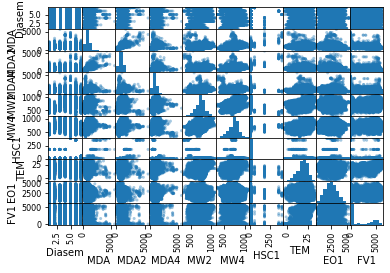

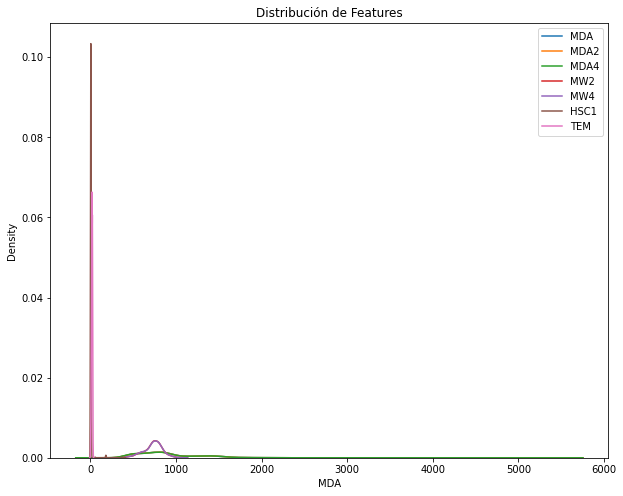

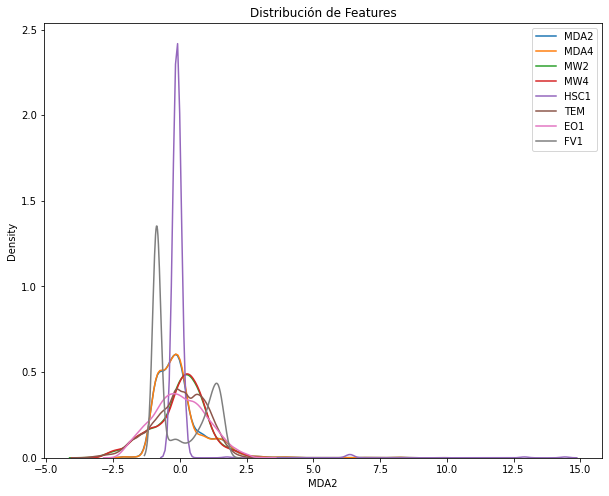

In [76]:
date_rng=['01/01/2021 01','01/01/2023 00']
hist_data=df_pml[date_rng[0]:date_rng[1]]

val_data=df_pml['01/01/2023 01':]
val_data

pml_data=hist_data[['Diasem','MDA','MDA2','MDA4','MW2','MW4','HSC1','TEM','EO1','FV1']]
#pml_data=hist_data[['MDA','MDA2','MDA3','MDA4','MW2','MW3','MW4','HSC1','TEM']]
pd.plotting.scatter_matrix(pml_data,alpha=0.4);

fig,ax=plt.subplots(figsize=(10, 8))
ax.set_title('Distribución de Features')

sns.kdeplot(pml_data['MDA'],ax=ax,label='MDA')
sns.kdeplot(pml_data['MDA2'],ax=ax,label='MDA2')
#sns.kdeplot(pml_data['MDA3'],ax=ax,label='MDA3')
sns.kdeplot(pml_data['MDA4'],ax=ax,label='MDA4')
sns.kdeplot(pml_data['MW2'],ax=ax,label='MW2')
#sns.kdeplot(pml_data['MW3'],ax=ax,label='MW3')
sns.kdeplot(pml_data['MW4'],ax=ax,label='MW4')
sns.kdeplot(pml_data['HSC1'],ax=ax,label='HSC1')
sns.kdeplot(pml_data['TEM'],ax=ax,label='TEM');
#sns.kdeplot(pml_data['EO1'],ax=ax,label='EO1')
#sns.kdeplot(pml_data['FV1'],ax=ax,label='FV1');
ax.legend();

X,y=pml_data.drop('MDA',axis=1),pml_data['MDA']
cols=X.columns.tolist()

# Input vars for LMP
# Selección de variable a pronosticar y datos de entrada a modelos
X_train,X_test,y_train,y_test=train_test_split(X,y,shuffle=False)

# Create scaler object
ss = StandardScaler()
# Fit scaler to training data
ss.fit(X_train)

# Transform train and test X data and save as new variables
X_train_scaled = pd.DataFrame(ss.transform(X_train),columns=cols,index=X_train.index)
X_test_scaled = pd.DataFrame(ss.transform(X_test),columns=cols,index=X_test.index)

fig,ax=plt.subplots(figsize=(10, 8))
ax.set_title('Distribución de Features')

sns.kdeplot(X_train_scaled['MDA2'],ax=ax,label='MDA2')
#sns.kdeplot(X_train_scaled['MDA3'],ax=ax,label='MDA3')
sns.kdeplot(X_train_scaled['MDA4'],ax=ax,label='MDA4')
sns.kdeplot(X_train_scaled['MW2'],ax=ax,label='MW2')
#sns.kdeplot(X_train_scaled['MW3'],ax=ax,label='MW3')
sns.kdeplot(X_train_scaled['MW4'],ax=ax,label='MW4')
sns.kdeplot(X_train_scaled['HSC1'],ax=ax,label='HSC1')
sns.kdeplot(X_train_scaled['TEM'],ax=ax,label='TEM')
sns.kdeplot(X_train_scaled['EO1'],ax=ax,label='EO1')
sns.kdeplot(X_train_scaled['FV1'],ax=ax,label='FV1');
ax.legend();

start_time = time.time()

res=[]
for k,reg in enumerate(mdl):
    pipe_tst=Pipeline(steps=[
        ('preprocessor',StandardScaler()),
        ('selector',ClfSwitcher(reg))
    ])
    gs=GridSearchCV(pipe_tst,params[k])
    gs.fit(X_train,y_train)
    res.append([gs.best_estimator_,gs.best_params_,gs.best_score_,gs.score(X_test,y_test)])
    
res_24m=pd.DataFrame(res,columns=['Model','Params','TrainR2','TestR2'])

print("--- %s seconds ---" % (time.time() - start_time))

G=val_data.loc['12/01/2023 01':'13/01/2023 00',cols];H=val_data.loc['12/01/2023 01':'13/01/2023 00','MDA']
best_model=res_24m['Model'][res_24m['TestR2']==max(res_24m['TestR2'])].values[0]
y_hat=best_model.predict(G)
ape=abs(H.values-y_hat)/y_hat
mape=ape.mean()
print(best_model.score(G,H),mape)

res_24m